## Логистическая регрессия в sklearn

Напомним:

$$
Y \sim Bern\left(\sigma(\theta^Tx)\right), \quad \sigma(z) = \frac{1}{1+e^{-z}},
$$
$Y \in {0, 1}$ - метка класса

$x = (1, x_1, \ldots, x_d)$ - признак

$\theta = (\theta_0, \theta_1, \ldots, x_d)$ - параметры

Оптимизационная задача:
$$
L(\theta) = -\sum_{i=1}^n \left[Y_i \ln \sigma(\theta^Tx_i) + (1 - Y_i)\ln\left(1 - \sigma(\theta^Tx_i)\right)\right] \to \min_\theta
$$
Решать мы ее, конечно же, не будем. Ведь у нас есть...

**sklearn.linear_model.LogisticRegression**(fit_intercept=True):
* fit_intercept - добавлять ли к данным столбец из единиц

Методы:
* fit(X, y) - обучение
* predict_proba(X) - массив размера (n, 2) - вероятности классов

Поля:
* intercept_ - свободный член
* coef_ - остальные параметры

In [ ]:
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(font_scale=1.5, style='whitegrid')

Датасет - [Key Indicators of Heart Disease](https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease)

Вещественные переменные:
1. BMI - индекс массы
2. PhysicalHealth - сколько из последних 30 дней пациент чувствовал себя плохо
3. MentalHealth - сколько из последних 30 дней пациент чувствовал себя плохо физически
4. SleepTime - сколько спит в день


Бинарные переменные:
1. Smoking - выкурил ли человек за жизнь 100 сигарет
2. AlcoholDrinking - для мужчин: пьет 14 напитков в неделю, для женщин - больше 7
3. Stroke - был ли инсульт
4. DiffWalking - есть ли сложности с ходьбой или поднятием по лестнице
5. Sex - Male / Female
6. PhysicalActivity - в последние 30 дней занимались спортом больше, чем основной работой
7. Asthma - есть/была астма
8. KidneyDisease - были ли болезни почек (кроме камней, ...)
9. SkinCancer - был ли рак кожи

Категориальные переменные:
1. AgeCategory - возраст
2. Race - раса
3. Diabetic - есть/был диабет (Yes / No / ...)
5. GenHealth - как пациент оценивает свое здоровье

Таргет - HeartDisease - была ли ишемическая болезнь сердца либо инфаркт миокарда

In [2]:
train = pd.read_csv('./train.csv')
data_train = train.iloc[:, 1:]
target_train = train.iloc[:, 0]

val = pd.read_csv('./val.csv')
data_val = val.iloc[:, 1:]
target_val = val.iloc[:, 0]

test = pd.read_csv('./test.csv')
data_test = test.iloc[:, 1:]
target_test = test.iloc[:, 0]

In [1]:
data_train

NameError: name 'data_train' is not defined

In [4]:
target_train

0         No
1         No
2         No
3         No
4         No
          ..
204663    No
204664    No
204665    No
204666    No
204667    No
Name: HeartDisease, Length: 204668, dtype: object

Так можно посмотреть, какое количество разных значений в массиве. С пропусками работает неправильно

In [5]:
np.unique(target_train, return_counts=True)

(array(['No', 'Yes'], dtype=object), array([187331,  17337], dtype=int64))

Так можно посмотреть, какие признаки содержат пропуски:

In [11]:
data_train.isna().any()

BMI                 False
Smoking              True
AlcoholDrinking     False
Stroke              False
PhysicalHealth      False
MentalHealth        False
DiffWalking          True
Sex                 False
AgeCategory         False
Race                 True
Diabetic            False
PhysicalActivity     True
GenHealth           False
SleepTime            True
Asthma              False
KidneyDisease       False
SkinCancer          False
dtype: bool

Преобразуем таргет к требуемому виду:

In [6]:
y_train = (target_train == 'Yes').astype(int)
y_val = (target_val == 'Yes').astype(int)
y_test = (target_test == 'Yes').astype(int)

Обучим регрессию на вещественных признаках:

In [77]:
real_features = ['BMI', 'PhysicalHealth', 'MentalHealth']

In [78]:
X_train = data_train[real_features]

In [79]:
model = LogisticRegression(fit_intercept=True, penalty='none')

In [80]:
model.fit(X_train, y_train)

LogisticRegression(penalty='none')

Свободный член и коэффициенты модели:

In [81]:
model.intercept_, model.coef_

(array([-3.12786565]), array([[ 0.01802468,  0.05311824, -0.00854678]]))

Посчитаем предсказания модели:

In [82]:
X_val = data_val[real_features]

predict_proba возвращает вероятности обоих классов. Нас интересует только первый:

In [83]:
predict_val = model.predict_proba(X_val)[:, 1]

## ROC AUC

Реализуем алгоритм из презентации (там можно посмотреть подробнее):
1. Идем по убыванию предсказаний
2. Двигаемся вправо на количество элементов класса 0, вверх на число элементов класса 1 

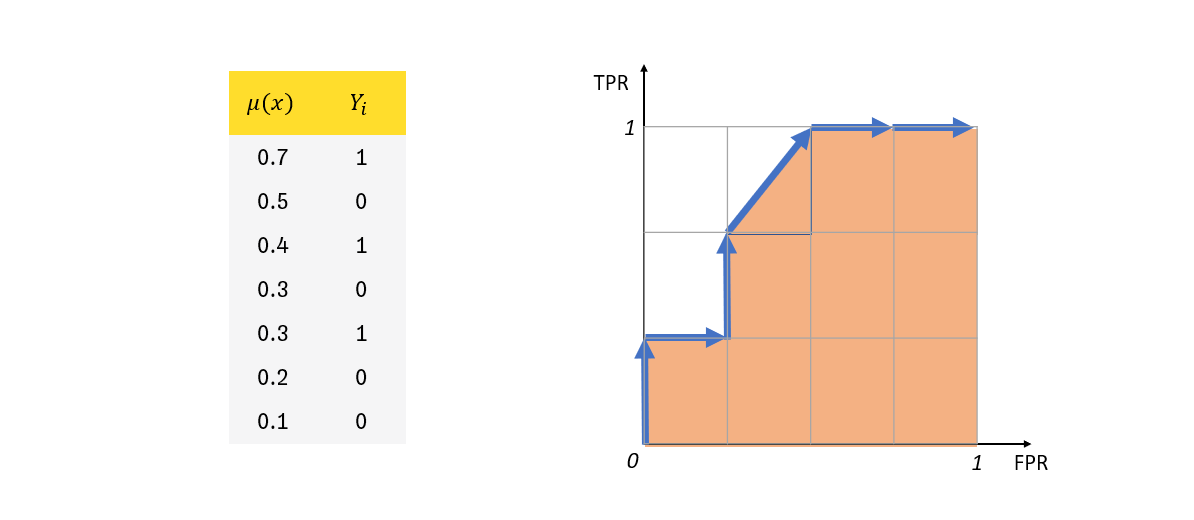

In [88]:
def roc_auc(y_true, y_pred):
    """Считает ROC AUC
    y_true - метки классов (0/1)
    y_pred - предсказания модели
    """
    n1_all = np.sum(y_true)
    n0_all = len(y_true) - n1_all
    
    df = pd.DataFrame()
    df['y_true'] = y_true
    df['y_pred'] = y_pred
    
    df = df.groupby('y_pred').agg({'y_true' : ['sum', 'count']})
    df.iloc[:, 1] -= df.iloc[:, 0]
    df.columns = ['n1', 'n0']
    
    #df = df.sort_values('y_pred', ascending=False)
    
    df = df.iloc[::-1, :]
    
    tpr = [0]
    fpr = [0]
    roc_auc = 0.0
    
    for i in range(len(df)):
        tpr.append(tpr[-1] + df.iloc[i]['n1'] / n1_all)
        fpr.append(fpr[-1] + df.iloc[i]['n0'] / n0_all)
        roc_auc += (fpr[-1] - fpr[-2]) * (tpr[-1] + tpr[-2]) / 2
        
    plt.figure(figsize=(7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], ls='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'ROC AUC = {roc_auc:.3f}')
        
    return roc_auc

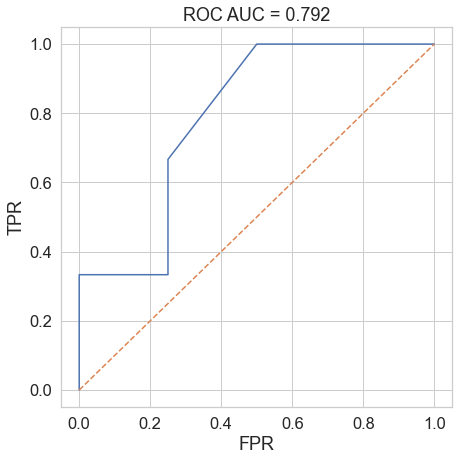

In [89]:
roc_auc([1, 0, 1, 0, 1, 0, 0], [0.6, 0.5, 0.3, 0.2, 0.2, 0.1, 0.0]);

0.6482675814987127

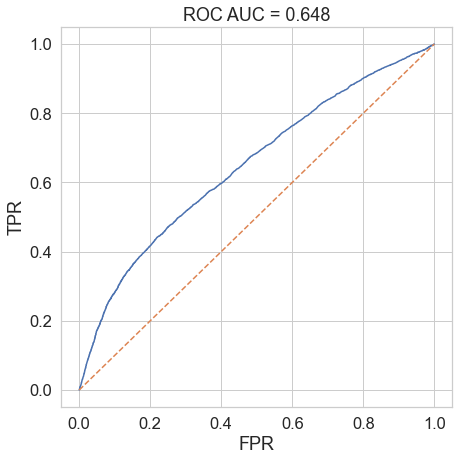

In [90]:
roc_auc(y_val, predict_val)

## Линейность признаков

Сейчас воспользуемся готовой реализацией woe_line, дома нужно будет написать свою

In [44]:
from risk_instruments.univariate import woe_line

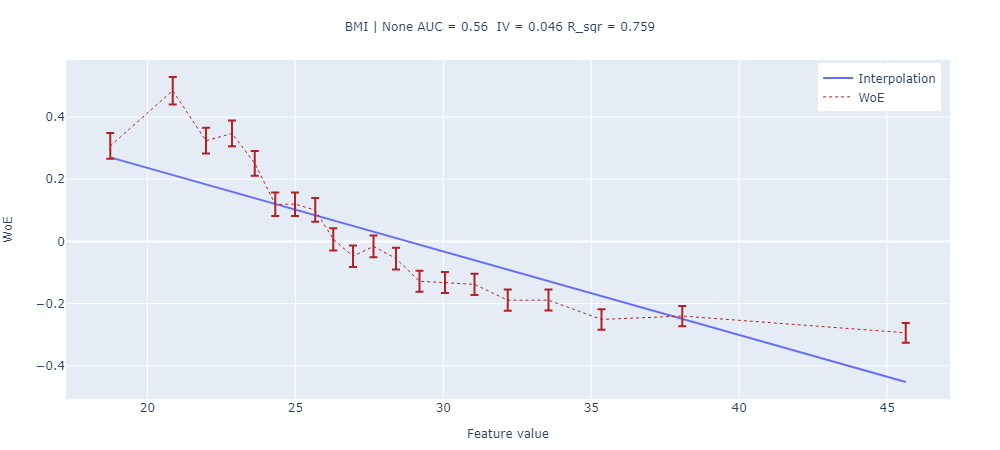

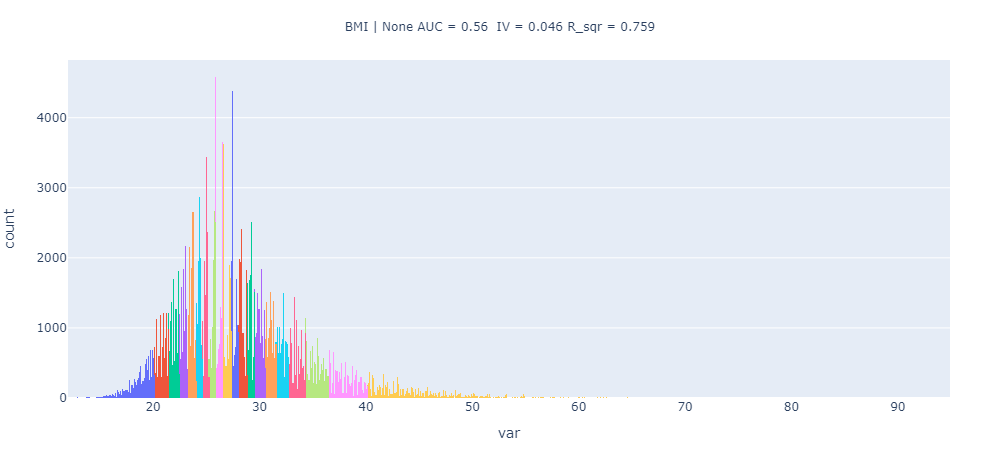

{'AUC': 0.56,
 'IV': 0.046,
 'R_sqr': 0.759,
 'n_obs': 204668,
 'n_buckets': 20,
 'coef': 0.17087296133040256}

In [46]:
woe_line(
    data_train['BMI'],
    y_train,
    n_buckets=20,
    var_nm='BMI'
)

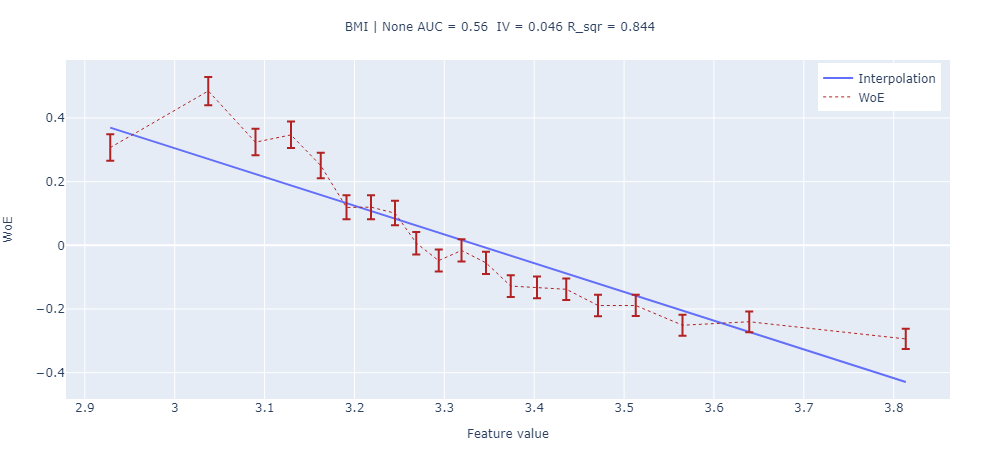

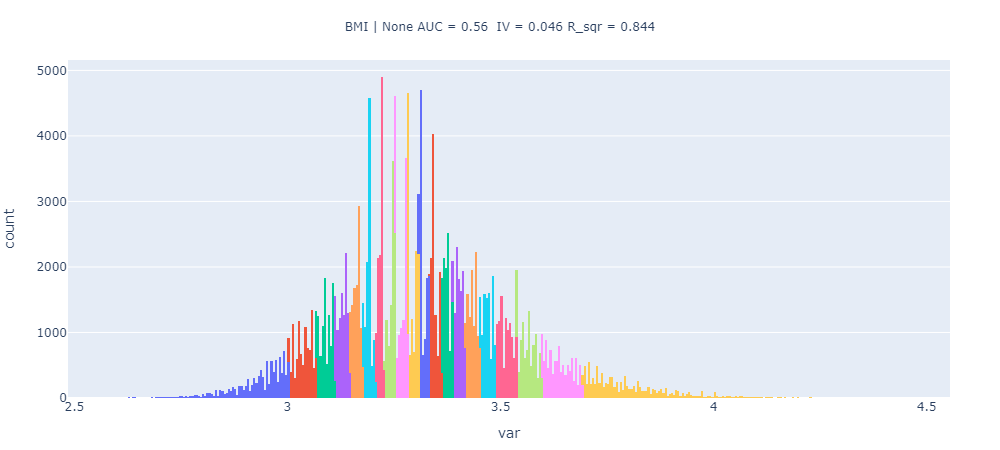

{'AUC': 0.56,
 'IV': 0.046,
 'R_sqr': 0.844,
 'n_obs': 204668,
 'n_buckets': 20,
 'coef': 0.1899270806837482}

In [47]:
woe_line(
    np.log(data_train['BMI']),
    y_train,
    n_buckets=20,
    var_nm='BMI'
)

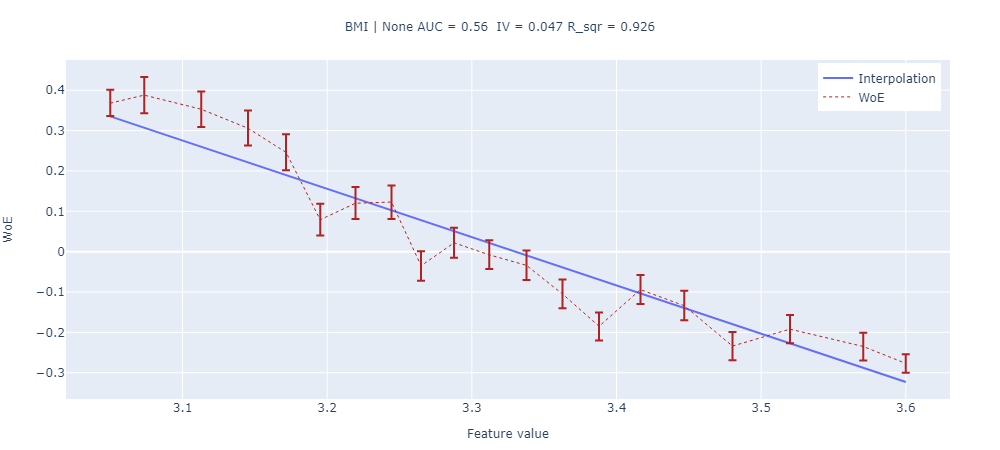

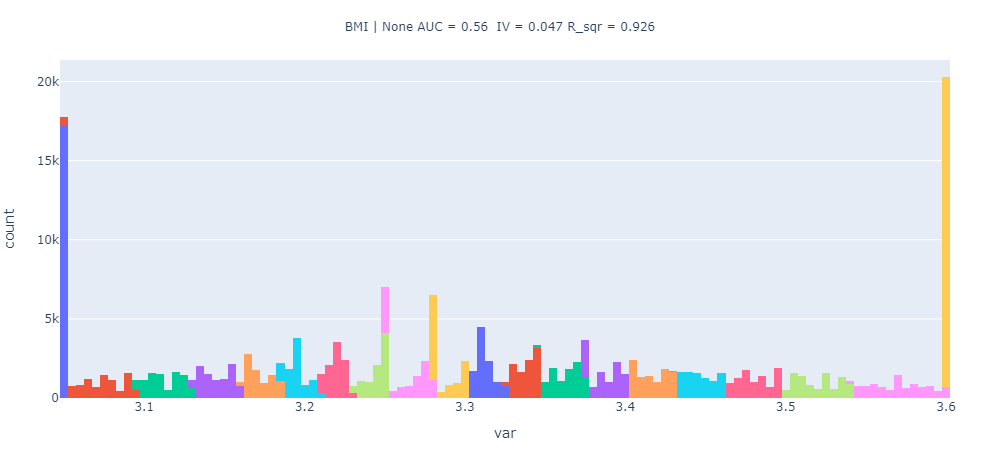

{'AUC': 0.56,
 'IV': 0.047,
 'R_sqr': 0.926,
 'n_obs': 204668,
 'n_buckets': 20,
 'coef': 0.20554568129063427}

In [49]:
woe_line(
    np.log(data_train['BMI']).clip(3.05, 3.6),
    y_train,
    n_buckets=20,
    var_nm='BMI'
)

In [91]:
def transform(X):
    X = X.copy()
    X['BMI'] = np.log(X['BMI']).clip(3.05, 3.6)
    return X

In [92]:
model = LogisticRegression(penalty='none')

In [93]:
model.fit(transform(X_train), y_train)

LogisticRegression(penalty='none')

In [94]:
predict_val = model.predict_proba(transform(X_val))[:, 1]

0.647890192987259

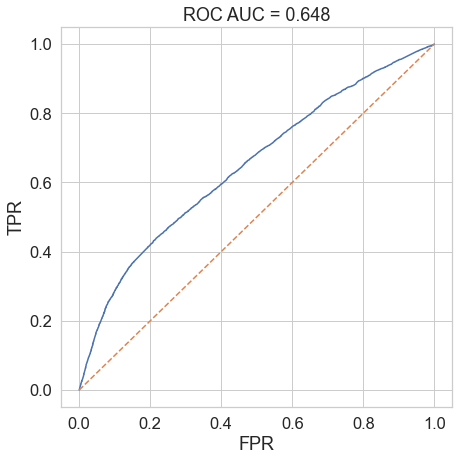

In [95]:
roc_auc(y_val, predict_val)

ROC AUC не увеличился. Однако, это не значит, что преобразования было лучше не делать: может идти конфликт с другими признаками, их тоже надо преобразовать, чтобы делать итоговый вывод.

## Бинарные признаки (флаги)

Надо привести к численному виду.

Метод 1 (переводит пропуски в нули):

In [96]:
(data_train['Stroke'] == 'Yes').astype(int)

0         0
1         0
2         0
3         0
4         0
         ..
204663    0
204664    0
204665    0
204666    0
204667    0
Name: Stroke, Length: 204668, dtype: int32

In [97]:
np.unique((data_train['Stroke'] == 'Yes').astype(int))

array([0, 1])

In [98]:
np.unique((data_train['Smoking'] == 'Yes').astype(int))

array([0, 1])

Метод 2 - переводит пропуски в пропуски

In [99]:
data_train['Smoking'].map({'No': 0, 'Yes': 1})

0         0.0
1         0.0
2         1.0
3         NaN
4         0.0
         ... 
204663    0.0
204664    1.0
204665    0.0
204666    0.0
204667    1.0
Name: Smoking, Length: 204668, dtype: float64

In [102]:
np.unique(data_train['Smoking'].map({'No': 0, 'Yes': 1}))

array([ 0.,  1., nan, ..., nan, nan, nan])

## Категориальные признаки

Признаки могут принимать много разных значений

In [64]:
data_train['AgeCategory'].unique()

array(['55-59', '65-69', '35-39', '45-49', '25-29', '30-34', '18-24',
       '75-79', '40-44', '50-54', '80 or older', '60-64', '70-74'],
      dtype=object)

Вариант 1 - сопоставить каждому варианту числовое значание

Вариант 2 - one-hot encoding.
Для переменной с k значениями заводим k-1 флаг (и свободный коэффициент)

In [65]:
from sklearn.preprocessing import OneHotEncoder

In [66]:
encoder = OneHotEncoder(sparse=False, drop='first')

In [71]:
encoder.fit_transform(data_train[['AgeCategory', 'Race']])

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [70]:
encoder.categories_

[array(['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54',
        '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older'],
       dtype=object),
 array(['American Indian/Alaskan Native', 'Asian', 'Black', 'Hispanic',
        'Other', 'White', nan], dtype=object)]

## Пропуски

Пропуски бывают двух видов:
1. Информативные
    * Не определен максимальный срок просрочки, потому что просрочки и не было
    * Тогда пропуск можно заменить любым значением и добавить флаг пропуска в модель
2. Неинформативные
    * Не определено последнее время захода в ЛК, потому что был недоступен сервис логирования
    * Клиент не сообщил какю-то информацию, потому что ее забыл
    * Таких пропусков в обучающей выборке может и не быть, поэтому флаг в модель добавить нельзя
    * Чем же тогда заполнять?

Надо заполнять значением, вносящим нулевой вклад: тем, которое на графике WoE соответствует нулевому значению WoE

Удалено 20361 строк с нуллами, осталось 184307


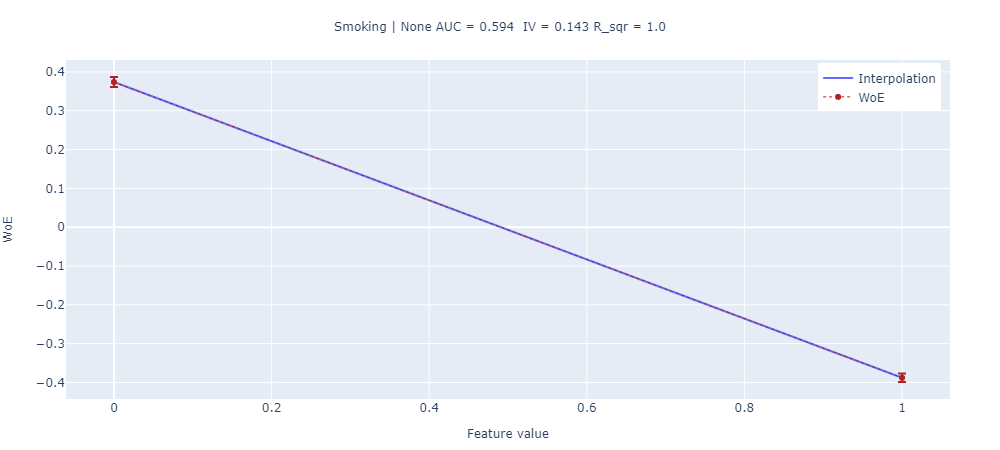

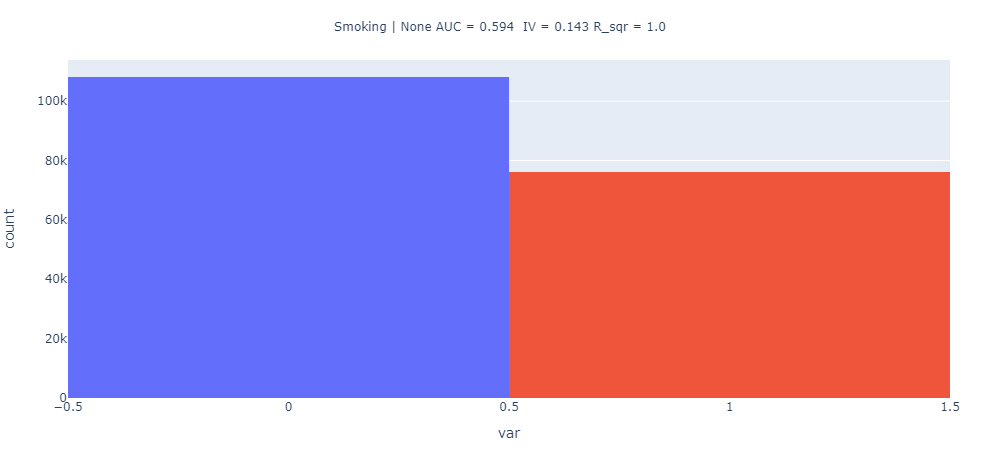

{'AUC': 0.594,
 'IV': 0.143,
 'R_sqr': 1.0,
 'n_obs': 184307,
 'n_buckets': 2,
 'coef': 0.37519142076364975}

In [104]:
woe_line(
    data_train['Smoking'].map({'No': 0, 'Yes': 1}),
    y_train,
    var_nm='Smoking'
)

Пропуски удобно заполнять функцией pandas.fillna

In [74]:
data_train['Smoking'].map({'No': 0, 'Yes': 1}).fillna(0.5)

0         0.0
1         0.0
2         1.0
3         0.5
4         0.0
         ... 
204663    0.0
204664    1.0
204665    0.0
204666    0.0
204667    1.0
Name: Smoking, Length: 204668, dtype: float64